# GRPO Fine Tuning Qwen3 4B on GSM8K

## install Libraries

In [ ]:
pip install unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 2.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.7/182.7 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.5/155.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/

## import libraries

In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"

try:
    import unsloth
except ImportError:
    print("Installing Unsloth...")
    os.system("pip install 'unsloth[colab-new]' --quiet")
    import unsloth

import re
import gc,random
import torch
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import set_seed
from unsloth import FastLanguageModel
from trl import GRPOConfig, GRPOTrainer
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import math
from huggingface_hub import HfApi
import json
from typing import Callable, List, Dict, Any, Optional, Tuple ,Any
from peft import PeftModel

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using

## Hyper parameters:

In [2]:
set_seed(3407)
torch.manual_seed(3407)

MAX_PROMPT_LEN   = 512
MAX_COMPLETION_LEN = 700
LORA_RANK        = 64
MODEL_NAME       = "Qwen/Qwen3-4B"

DATASET_NAME = "openai/gsm8k"
GRPO_OUTPUT_DIR = "outputs_grpo"
ADAPTER_REPO = "tahamajs/Qwen3-4b-gsm8k-Qlora-GRPO"
ADAPTER_DIR = "addapter-grpo"
DATASET_SPLIT = "test"
BATCH_SIZE = 5
NUM_SAMPLES = 5

W_STRICT = 0.5
W_SOFT   = 0.3
W_XML    = 0.2
W_CORR   = 2.0

W_LEN_SHAPING = 0.1
W_REPEAT_PEN  = 0.1

NUM_GENERATIONS = 4

W_STRICT = 0.5
W_SOFT   = 0.3
W_XML    = 0.2
W_CORR   = 2.0

PRINT_EVERY = 50
SHOW_SAMPLES = 0

In [3]:
_RE_STRICT = re.compile(
    r"^\s*<reasoning>\s*(.*?)\s*</reasoning>\s*<answer>\s*(.*?)\s*</answer>\s*$",
    re.DOTALL,
)
_NUM_RE = re.compile(r"[-+]?\d*\.\d+|\d+")


_RE_SOFT = re.compile(
    r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>",
    re.DOTALL,
)

_RE_NUM = re.compile(r"([+-]?\d{1,3}(?:,\d{3})*(?:\.\d+)?|[+-]?\d+(?:\.\d+)?)")

## Loading Model

### load base model for training

In [5]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name       = MODEL_NAME,
    max_seq_length   = MAX_PROMPT_LEN + MAX_COMPLETION_LEN,
    load_in_4bit     = True,
    dtype            = None,
)

FastLanguageModel.for_training(model)



==((====))==  Unsloth 2025.8.6: Fast Qwen3 patching. Transformers: 4.55.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 2560, padding_idx=151654)
    (layers): ModuleList(
      (0-1): 2 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=2560, out_features=4096, bias=False)
          (k_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=2560, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (up_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (down_proj): Linear(in_features=9728, out_features=2560, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RM

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = LORA_RANK,
    lora_alpha = LORA_RANK,
    lora_dropout = 0.05,
    target_modules = ["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    use_gradient_checkpointing = False,
    random_state = 3497,
)

### load adapter from huggingface

In [4]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=MODEL_NAME,
    load_in_4bit=True,
    dtype=None,
    device_map="auto",
)



==((====))==  Unsloth 2025.8.6: Fast Qwen3 patching. Transformers: 4.55.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [5]:
model = PeftModel.from_pretrained(
    model,
    ADAPTER_REPO,
    is_trainable=True,
)


### System Prompt:

In [6]:
SYSTEM_PROMPT = (
    "You are a helpful assistant.\n"
    "First think through the problem, then provide the answer.\n"
    "Use this strict format:\n"
    "<reasoning>\n"
    "your step-by-step reasoning here\n"
    "</reasoning>\n"
    "<answer>\n"
    "The final answer is [final_number].\n"
    "</answer>\n"
)

## Helper Functions:


In [7]:
def ensure_qwen_chat_template(tokenizer, force: bool = False):
    if not force and getattr(tokenizer, "chat_template", None):
        if tokenizer.pad_token is None and tokenizer.eos_token is not None:
            tokenizer.pad_token = tokenizer.eos_token
        return tokenizer

    needed_specials = ["<|im_start|>", "<|im_end|>"]
    to_add = [t for t in needed_specials if t not in tokenizer.get_vocab()]
    if to_add:
        tokenizer.add_special_tokens({"additional_special_tokens": to_add})

    if tokenizer.pad_token is None and tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token

    tokenizer.chat_template = (
        "{% for message in messages %}"
        "{% if message['role'] == 'system' %}"
        "<|im_start|>system\n{{ message['content'] }}<|im_end|>\n"
        "{% elif message['role'] == 'user' %}"
        "<|im_start|>user\n{{ message['content'] }}<|im_end|>\n"
        "{% elif message['role'] == 'assistant' %}"
        "<|im_start|>assistant\n{{ message['content'] }}<|im_end|>\n"
        "{% else %}"
        "<|im_start|>{{ message['role'] }}\n{{ message['content'] }}<|im_end|>\n"
        "{% endif %}"
        "{% endfor %}"
        "{% if add_generation_prompt %}<|im_start|>assistant\n{% endif %}"
    )
    return tokenizer

tokenizer = ensure_qwen_chat_template(tokenizer)

messages = [
    {"role": "system", "content": "You are a helpful math assistant."},
    {"role": "user",   "content": "What is 2 + 2?"},
]
formatted = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
print("---- formatted prompt ----")
print(formatted)

print("Model setup with Unsloth and LoRA is complete.")

---- formatted prompt ----
<|im_start|>system
You are a helpful math assistant.<|im_end|>
<|im_start|>user
What is 2 + 2?<|im_end|>
<|im_start|>assistant

Model setup with Unsloth and LoRA is complete.


In [8]:
def extract_hash_answer(text: str) -> str | None:
    if text is None:
        return None
    m = re.search(r"####\s*([^\n]+)", text)
    if not m:
        return None
    return m.group(1).strip().replace(",", "")

def get_gsm8k(split="train") -> Dataset:
    ds = load_dataset("openai/gsm8k", "main")[split]
    ds = ds.map(lambda x: {
        "prompt": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user",   "content": x["question"]},
        ],
        "answer": extract_hash_answer(x["answer"]),
        "question": x["question"],
    })
    ds = ds.filter(lambda x: x["answer"] is not None and len(x["answer"]) > 0)
    return ds


### Ploting Functions:

In [9]:

def plot_loss_curves(log_history, title="Training Progress"):
    """Plots training and validation loss curves from Trainer log history."""
    print(f"\nPlotting loss curves for {title}...")
    train_logs = [log for log in log_history if 'loss' in log]
    eval_logs = [log for log in log_history if 'eval_loss' in log]

    plt.figure(figsize=(12, 6))
    if train_logs:
        plt.plot([log['step'] for log in train_logs],
                 [log['loss'] for log in train_logs],
                 label='Training Loss')
    if eval_logs:
        plt.plot([log['step'] for log in eval_logs],
                 [log['eval_loss'] for log in eval_logs],
                 marker='o',
                 label='Validation Loss')

    plt.title(f'Loss Curves - {title}')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_metric(log_history, metric_name, title=None):
    """Plots a single metric over steps."""
    metric_logs = [log for log in log_history if metric_name in log]
    if not metric_logs:
        print(f"No logs found for metric: {metric_name}")
        return

    steps = [log['step'] for log in metric_logs]
    values = [log[metric_name] for log in metric_logs]

    plt.figure(figsize=(12, 6))
    plt.plot(steps, values, marker='o')
    plt.title(title or f'{metric_name} over Steps')
    plt.xlabel('Step')
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.show()


def plot_multiple_metrics(log_history, metric_names, title="Metrics Over Time"):
    """Plots multiple metrics on the same figure."""
    plt.figure(figsize=(12, 6))
    for metric_name in metric_names:
        metric_logs = [log for log in log_history if metric_name in log]
        if not metric_logs:
            print(f"Skipping {metric_name} (not found)")
            continue
        steps = [log['step'] for log in metric_logs]
        values = [log[metric_name] for log in metric_logs]
        plt.plot(steps, values, marker='o', label=metric_name)

    plt.title(title)
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_reward_components(log_history, reward_names=None, every_n=1):
    if reward_names is None:
        keys = set().union(*log_history)
        reward_names = [k for k in keys if k.startswith("reward") or k.startswith("r_")]

    for reward_name in reward_names:
        reward_logs = [log for log in log_history if reward_name in log]
        if not reward_logs:
            print(f"Skipping reward {reward_name} (not found)")
            continue

        steps = [log['step'] for log in reward_logs][::every_n]
        values = [log[reward_name] for log in reward_logs][::every_n]

        plt.figure(figsize=(12, 6))
        plt.plot(steps, values, marker='o', label=reward_name)
        plt.title(f'{reward_name} over Steps')
        plt.xlabel('Step')
        plt.ylabel('Reward')
        plt.grid(True)
        plt.legend()
        plt.show()


In [10]:
def create_prompt(problem_text: str) -> str:
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": problem_text},
    ]
    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

def extract_last_number(generated_text: str) -> str:
    if not generated_text: return ""
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", generated_text)
    return numbers[-1] if numbers else ""


def _extract_last_number(text: Optional[str]) -> str:
    if not text: return ""
    m = _NUM_RE.findall(text)
    return m[-1] if m else ""

def _get_question(ex: Dict[str, Any]) -> str:
    if "question" in ex:
        return ex["question"]
    if "messages" in ex and isinstance(ex["messages"], list) and len(ex["messages"]) >= 2:
        return ex["messages"][1].get("content", "")
    raise KeyError("Example is missing a 'question' or chat-style 'messages' field.")

def _get_reference_answer(ex: Dict[str, Any]) -> str:
    if "answer" in ex and ex["answer"] is not None and ex["answer"] != "":
        return str(ex["answer"])
    if "answer_text" in ex and ex["answer_text"]:
        return _extract_last_number(ex["answer_text"])
    if "solution" in ex:
        return _extract_last_number(ex["solution"])
    return ""

def _detect_model_dtype(model) -> Optional[torch.dtype]:
    dt = getattr(getattr(model, "config", None), "torch_dtype", None)
    if dt is None:
        try:
            dt = model.get_input_embeddings().weight.dtype
        except Exception:
            dt = None
    return dt




def evaluate_self_consistency(
    model,
    tokenizer,
    dataset,
    create_prompt: Callable[[str], str],
    num_samples: int = 5,
    batch_size: int = 8,
    max_new_tokens: int = 512,
    temperature: float = 0.7,
    top_p: float = 0.9,
    max_input_len: int = 2048,
    verbose: bool = True,
) -> Dict[str, Any]:
    try:
        tokenizer.padding_side = "right"
    except Exception:
        pass
    if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
        tokenizer.pad_token = tokenizer.eos_token

    if hasattr(dataset, "__len__") and hasattr(dataset, "__getitem__"):
        ds_len = len(dataset)
        get_item = dataset.__getitem__
    else:
        raise TypeError("dataset must be indexable and have __len__ / __getitem__.")

    device = getattr(model, "device", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    model_dtype = _detect_model_dtype(model)

    try:
        model.gradient_checkpointing_disable()
    except Exception:
        pass
    try:
        model.config.use_cache = True
    except Exception:
        pass

    model.eval()

    if verbose:
        print(f"\n--- Starting evaluation with Self-Consistency (samples: {num_samples}) ---")

    predictions: List[str] = []
    references: List[str] = []

    for i in tqdm(range(0, ds_len, batch_size), desc="Evaluating Batches"):
        batch = [get_item(k) for k in range(i, min(i + batch_size, ds_len))]

        batch_questions = [_get_question(ex) for ex in batch]
        batch_prompts   = [create_prompt(q) for q in batch_questions]
        batch_refs      = [_get_reference_answer(ex) for ex in batch]

        enc = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_input_len,
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        with torch.no_grad():
            use_autocast = (device.type == "cuda") and (model_dtype in (torch.float16, torch.bfloat16))
            if use_autocast:
                with torch.autocast(device_type="cuda", dtype=model_dtype):
                    outputs = model.generate(
                        **enc,
                        max_new_tokens=max_new_tokens,
                        do_sample=True,
                        temperature=temperature,
                        top_p=top_p,
                        num_return_sequences=num_samples,
                        pad_token_id=tokenizer.eos_token_id,
                    )
            else:
                outputs = model.generate(
                    **enc,
                    max_new_tokens=max_new_tokens,
                    do_sample=True,
                    temperature=temperature,
                    top_p=top_p,
                    num_return_sequences=num_samples,
                    pad_token_id=tokenizer.eos_token_id,
                )

        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        for j, prompt in enumerate(batch_prompts):
            start = j * num_samples
            end   = start + num_samples
            samples_for_prompt = decoded[start:end]

            sample_answers: List[str] = []
            for text in samples_for_prompt:
                completion_only = text[len(prompt):]
                ans = _extract_last_number(completion_only)
                if ans:
                    sample_answers.append(ans)

            final_answer = ""
            if sample_answers:
                vote_counts = Counter(sample_answers)
                final_answer = vote_counts.most_common(1)[0][0]

            predictions.append(final_answer)
            if verbose:
                print(f"Samples: {sample_answers} -> Voted: {final_answer}, Reference: {batch_refs[j]}")

        references.extend(batch_refs)

    correct = sum(1 for p, r in zip(predictions, references) if (r != "" and p == r))
    total = len(references)
    acc = (correct / total) * 100 if total else 0.0

    if verbose:
        print("\n--- Evaluation Complete ---")
        print(f"Correct Answers: {correct} / {total}")
        print(f"Accuracy: {acc:.2f}%")

    return {
        "accuracy": acc,
        "correct": correct,
        "total": total,
        "predictions": predictions,
        "references": references,
    }


### saving functions

In [11]:
def save_trainer_bundle(trainer, tokenizer, out_dir: str,
                        save_merged_full_model: bool = False,
                        merged_dir: Optional[str] = None):
    os.makedirs(out_dir, exist_ok=True)
    trainer.save_model(out_dir)
    tokenizer.save_pretrained(out_dir)
    trainer.save_state()

    try:
        with open(os.path.join(out_dir, "log_history.json"), "w") as f:
            json.dump(trainer.state.log_history, f, indent=2)
    except Exception as e:
        print(f"Warning: could not write log_history.json: {e}")

    print(f"✅ Saved model/adapter, tokenizer, and trainer state to: {out_dir}")

    if save_merged_full_model:
        if merged_dir is None:
            merged_dir = os.path.join(out_dir, "merged_full_model")
        os.makedirs(merged_dir, exist_ok=True)

        model = trainer.model
        if isinstance(model, PeftModel):
            print("Merging LoRA into base model for a standalone checkpoint...")
            merged = model.merge_and_unload()
            merged.save_pretrained(merged_dir, safe_serialization=True)
            tokenizer.save_pretrained(merged_dir)
            print(f"✅ Saved merged full model to: {merged_dir}")
        else:
            print("Model is not a PEFT/LoRA model; skipping merge (already full model).")


### Parsing / utilities


In [12]:
def _strip_commas(s: str) -> str:
    return s.replace(",", "")

def _to_float_safe(s: Optional[str]) -> Optional[float]:
    if s is None:
        return None
    try:
        return float(_strip_commas(s).strip())
    except Exception:
        return None

def extract_last_number(text: Optional[str]) -> Optional[str]:
    if not text:
        return None
    m = list(_RE_NUM.finditer(text))
    if not m:
        return None
    return m[-1].group(1)

def strict_xml_ok(text: str) -> bool:
    return _RE_STRICT.match(text) is not None

def soft_xml_ok(text: str) -> bool:
    return _RE_SOFT.search(text) is not None

def _tag_counts(text: str) -> Dict[str, int]:
    return {
        "open_reasoning": text.count("<reasoning>"),
        "close_reasoning": text.count("</reasoning>"),
        "open_answer": text.count("<answer>"),
        "close_answer": text.count("</answer>"),
    }

def _trailing_after_answer(text: str) -> str:
    if "</answer>" not in text:
        return text
    return text.split("</answer>", 1)[-1]

def xml_counter(text: str) -> float:
    score = 0.0
    counts = _tag_counts(text)

    score += 0.125 if counts["open_reasoning"] == 1 else 0.0
    score += 0.125 if counts["close_reasoning"] == 1 else 0.0
    score += 0.125 if counts["open_answer"] == 1 else 0.0
    score += 0.125 if counts["close_answer"] == 1 else 0.0

    if (counts["open_reasoning"] != counts["close_reasoning"]) or (counts["open_answer"] != counts["close_answer"]):
        score -= 0.25
    if counts["open_reasoning"] > 1 or counts["open_answer"] > 1:
        score -= 0.25

    trail = _trailing_after_answer(text).strip()
    if trail:
        score -= min(len(trail) * 0.001, 0.5)
    return score

def _numbers_equal(gold: Optional[str], pred: Optional[str], rtol=1e-6, atol=1e-8) -> bool:
    g = _to_float_safe(gold)
    p = _to_float_safe(pred)
    if g is None or p is None:
        return False
    return math.isclose(g, p, rel_tol=rtol, abs_tol=atol)

def _len_shaping(text: str, target_max_chars: int = 1200) -> float:
    n = len(text)
    if n <= target_max_chars:
        return 0.2 * (1.0 - n / target_max_chars)
    over = n - target_max_chars
    return -min(over / target_max_chars * 0.2, 0.2)

def _repeat_penalty(text: str, n: int = 3) -> float:
    toks = text.split()
    if len(toks) < n:
        return 0.0
    seen = {}
    for i in range(len(toks) - n + 1):
        ng = tuple(toks[i:i+n])
        seen[ng] = seen.get(ng, 0) + 1
    repeats = sum(c - 1 for c in seen.values() if c > 1)
    return -min(repeats * 0.05, 0.2)

### Reward Functions

In [13]:
def r_strict(prompts, completions, **kwargs):
    texts = [c[0]["content"] for c in completions]
    base = [1.0 if strict_xml_ok(t) else 0.0 for t in texts]
    vals = [W_STRICT * b for b in base]
    _maybe_print_stats("r_strict", vals)
    return vals

def r_soft(prompts, completions, **kwargs):
    texts = [c[0]["content"] for c in completions]
    base = [1.0 if soft_xml_ok(t) else 0.0 for t in texts]
    vals = [W_SOFT * b for b in base]
    _maybe_print_stats("r_soft", vals)
    return vals

def r_xmlcount(prompts, completions, **kwargs):
    texts = [c[0]["content"] for c in completions]
    vals = [W_XML * xml_counter(t) for t in texts]
    _maybe_print_stats("r_xmlcount", vals)
    return vals
def r_correctness(prompts, completions, answer, **kwargs):
    texts = [c[0]["content"] for c in completions]
    preds = [extract_last_number(t) for t in texts]
    golds = answer

    raw = [(1.0 if _numbers_equal(g, p) else 0.0) for g, p in zip(golds, preds)]
    vals = [W_CORR * v for v in raw]

    vals_tensor = torch.tensor(vals, dtype=torch.float32, device=kwargs.get("device", "cuda"))

    if kwargs.get("verbose", False):
        _maybe_print_stats(
            "r_correctness", vals,
            extra_info={"batch_acc": sum(raw)/len(raw) if raw else 0.0}
        )

    return vals_tensor

def r_shaping(prompts, completions, **kwargs):
    if W_LEN_SHAPING == 0.0 and W_REPEAT_PEN == 0.0:
        return [0.0 for _ in completions]
    texts = [c[0]["content"] for c in completions]
    vals = []
    for t in texts:
        v = 0.0
        if W_LEN_SHAPING:
            v += W_LEN_SHAPING * _len_shaping(t)
        if W_REPEAT_PEN:
            v += W_REPEAT_PEN * _repeat_penalty(t, n=3)
        vals.append(v)
    _maybe_print_stats("r_shaping", vals)
    return vals


### Printing helpers

In [14]:
_PRINT_CTR = {}

def _maybe_print_stats(name: str, values: List[float], extra_info: Dict[str, Any] = None):
    if PRINT_EVERY <= 0:
        return
    cnt = _PRINT_CTR.get(name, 0) + 1
    _PRINT_CTR[name] = cnt
    if cnt % PRINT_EVERY != 0:
        return
    if not values:
        print(f"[{name}] call={cnt} (empty batch)")
        return
    mean = sum(values) / len(values)
    mn, mx = min(values), max(values)
    line = f"[{name}] call={cnt} batch={len(values)} mean={mean:.4f} min={mn:.4f} max={mx:.4f}"
    if extra_info:
        for k, v in extra_info.items():
            line += f" {k}={v:.4f}" if isinstance(v, (int, float)) else f" {k}={v}"
    print(line)
    if SHOW_SAMPLES > 0:
        print(f"  samples: {values[:SHOW_SAMPLES]}")

def print_reward_breakdown_for_batch(
    prompts, completions, answer, max_items: int = 3, truncate: int = 160
):
    texts = [c[0]["content"] for c in completions]
    golds = answer
    for idx, (t, g) in enumerate(zip(texts, golds)):
        if idx >= max_items: break
        pred = extract_last_number(t)
        comp = {
            "strict":      1.0 if strict_xml_ok(t) else 0.0,
            "soft":        1.0 if soft_xml_ok(t) else 0.0,
            "xmlcount":    xml_counter(t),
            "correctness": 1.0 if _numbers_equal(g, pred) else 0.0,
            "len_shape":   _len_shaping(t) if W_LEN_SHAPING else 0.0,
            "repeat_pen":  _repeat_penalty(t) if W_REPEAT_PEN else 0.0,
        }
        total = (W_STRICT*comp["strict"] + W_SOFT*comp["soft"] + W_XML*comp["xmlcount"]
                 + W_CORR*comp["correctness"]
                 + W_LEN_SHAPING*comp["len_shape"] + W_REPEAT_PEN*comp["repeat_pen"])
        preview = (t[:truncate] + "…") if len(t) > truncate else t
        print(f"\n--- Reward breakdown: sample {idx} ---")
        print(f"gold: {g} | pred: {pred}")
        print(f"preview: {preview}")
        print(f"components: {comp}")
        print(f"weighted total (intuition): {total:.4f}")


## Load *Dataset*

In [15]:
full_main_dataset = get_gsm8k("train")

print(f"\nTaking a 2% subset of the main dataset ({len(full_main_dataset)} examples)...")
subset_split = full_main_dataset.train_test_split(train_size=0.1, seed=42)
working_dataset = subset_split['train']
print(f"Working with {len(working_dataset)} examples now.")

final_split = working_dataset.train_test_split(test_size=0.2, seed=42)
train_ds, test_ds = final_split["train"], final_split["test"]




Taking a 2% subset of the main dataset (7473 examples)...
Working with 747 examples now.


## Test BaseLine

#### test with 20 samples

In [21]:
samples = random.sample(list(full_main_dataset), 40)


results = evaluate_self_consistency(
    model=model,
    tokenizer=tokenizer,
    dataset=samples,
    create_prompt=create_prompt,
    num_samples=5,
    batch_size=8,
    max_new_tokens=512,
)

print(f"Final accuracy: {results['accuracy']:.2f}%")


--- Starting evaluation with Self-Consistency (samples: 5) ---


Evaluating Batches:  33%|███▎      | 1/3 [03:45<07:31, 225.85s/it]

Samples: ['700', '700', '700', '700', '700'] -> Voted: 700, Reference: 700
Samples: ['13', '39', '13', '39', '39'] -> Voted: 39, Reference: 39
Samples: ['7', '7', '7', '7', '7'] -> Voted: 7, Reference: 7
Samples: ['6', '6', '6', '6', '6'] -> Voted: 6, Reference: 6
Samples: ['4', '4', '4', '4', '4'] -> Voted: 4, Reference: 4
Samples: ['120', '132', '131', '142', '142'] -> Voted: 142, Reference: 142
Samples: ['130', '250', '130', '130', '130'] -> Voted: 130, Reference: 130
Samples: ['20', '20', '20'] -> Voted: 20, Reference: 20


Evaluating Batches:  67%|██████▋   | 2/3 [07:23<03:41, 221.01s/it]

Samples: ['13', '13', '13', '13', '13'] -> Voted: 13, Reference: 13
Samples: ['570', '570', '570', '570', '570'] -> Voted: 570, Reference: 570
Samples: ['81', '81', '81', '81', '81'] -> Voted: 81, Reference: 81
Samples: ['4096', '4096', '4096', '4096', '4096'] -> Voted: 4096, Reference: 4096
Samples: ['7', '7', '7', '7', '7'] -> Voted: 7, Reference: 7
Samples: ['4', '3', '100', '3', '3'] -> Voted: 3, Reference: 810
Samples: ['20', '20', '20', '20', '20'] -> Voted: 20, Reference: 20
Samples: ['60', '60', '60', '60', '60'] -> Voted: 60, Reference: 60


/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:660: UserWarning: An output with one or more elements was resized since it had shape [1, 20, 2560], which does not match the required output shape [20, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /pytorch/aten/src/ATen/native/Resize.cpp:31.)
  out = torch_matmul(X, W.t(), out = out)
/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:665: UserWarning: An output with one or more elements was resized since it had shape [1, 20, 2560], which does not match the required output shape [20, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t

Samples: ['180', '310', '180', '3', '180'] -> Voted: 180, Reference: 180
Samples: ['19', '19', '19', '19', '19'] -> Voted: 19, Reference: 19
Samples: ['24', '24', '24', '24', '24'] -> Voted: 24, Reference: 24
Samples: ['13', '13', '13', '13', '13'] -> Voted: 13, Reference: 13

--- Evaluation Complete ---
Correct Answers: 19 / 20
Accuracy: 95.00%
Final accuracy: 95.00%


#### test with 40 samples

In [22]:
samples = random.sample(list(full_main_dataset), 40)


results = evaluate_self_consistency(
    model=model,
    tokenizer=tokenizer,
    dataset=samples,
    create_prompt=create_prompt,
    num_samples=5,
    batch_size=8,
    max_new_tokens=512,
)

print(f"Final accuracy: {results['accuracy']:.2f}%")


--- Starting evaluation with Self-Consistency (samples: 5) ---


Evaluating Batches:  20%|██        | 1/5 [03:34<14:17, 214.26s/it]

Samples: ['68', '84', '84', '84', '84'] -> Voted: 84, Reference: 84
Samples: ['150', '5', '150', '5', '000'] -> Voted: 150, Reference: 150
Samples: ['60', '60', '60', '60', '60'] -> Voted: 60, Reference: 60
Samples: ['84', '84', '84', '84', '84'] -> Voted: 84, Reference: 84
Samples: ['70', '5', '2', '240', '46'] -> Voted: 70, Reference: 46
Samples: ['32139', '32139', '32139', '32139', '139'] -> Voted: 32139, Reference: 32139
Samples: ['000', '000', '000', '0', '000'] -> Voted: 000, Reference: 60000
Samples: ['216', '216', '216', '216', '216'] -> Voted: 216, Reference: 216


Evaluating Batches:  40%|████      | 2/5 [07:13<10:51, 217.01s/it]

Samples: ['15', '15', '15', '15', '15'] -> Voted: 15, Reference: 15
Samples: ['70', '70', '70', '70', '70'] -> Voted: 70, Reference: 70
Samples: ['8', '8', '8', '8', '8'] -> Voted: 8, Reference: 8
Samples: ['16', '16', '16', '16', '16'] -> Voted: 16, Reference: 16
Samples: ['6.00', '6', '6', '6.00', '6.00'] -> Voted: 6.00, Reference: 6
Samples: ['4', '4', '4', '4', '4'] -> Voted: 4, Reference: 4
Samples: ['5', '2', '155', '1', '5'] -> Voted: 5, Reference: 155
Samples: ['12000', '12000', '12000', '12000', '12000'] -> Voted: 12000, Reference: 12000


Evaluating Batches:  60%|██████    | 3/5 [10:58<07:21, 220.95s/it]

Samples: ['105', '105', '45', '45', '10'] -> Voted: 105, Reference: 45
Samples: ['96', '96', '96', '96', '96'] -> Voted: 96, Reference: 96
Samples: ['18', '0', '1', '1', '68'] -> Voted: 1, Reference: 22
Samples: ['325', '325', '325', '325', '325'] -> Voted: 325, Reference: 325
Samples: ['40', '40', '40', '40', '40'] -> Voted: 40, Reference: 40
Samples: ['32', '32', '32', '32', '32'] -> Voted: 32, Reference: 32
Samples: ['14', '14', '14', '14', '14'] -> Voted: 14, Reference: 14
Samples: ['0', '60', '60', '60', '60'] -> Voted: 60, Reference: 60


Evaluating Batches:  80%|████████  | 4/5 [14:36<03:39, 219.57s/it]

Samples: ['70', '70', '70', '70', '70'] -> Voted: 70, Reference: 70
Samples: ['9', '9', '9', '9', '9'] -> Voted: 9, Reference: 9
Samples: ['69', '69', '69', '69', '69'] -> Voted: 69, Reference: 69
Samples: ['10', '10', '10', '10', '10'] -> Voted: 10, Reference: 10
Samples: ['18', '18', '18', '18', '18'] -> Voted: 18, Reference: 18
Samples: ['12200', '12200', '12200', '12200', '12200'] -> Voted: 12200, Reference: 12200
Samples: ['700', '700', '700', '700', '700'] -> Voted: 700, Reference: 700
Samples: ['330', '106', '106.5', '123', '95'] -> Voted: 330, Reference: 95


Evaluating Batches: 100%|██████████| 5/5 [18:26<00:00, 221.31s/it]

Samples: ['146', '146', '146', '146', '146'] -> Voted: 146, Reference: 146
Samples: ['116', '116', '116', '116', '116'] -> Voted: 116, Reference: 116
Samples: ['87', '87', '87', '87', '87'] -> Voted: 87, Reference: 87
Samples: ['20', '20', '20'] -> Voted: 20, Reference: 20
Samples: ['99', '99', '99', '99', '99'] -> Voted: 99, Reference: 99
Samples: ['50', '50', '50', '233.33', '2'] -> Voted: 50, Reference: 20
Samples: ['000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', '240', '240', '240', '240'] -> Voted: 240, Reference: 240
Samples: ['1', '1'] -> Voted: 1, Reference: 1

--- Evaluati

## Training Arguments

In [16]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")

if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
model.config.use_cache = True

try:
    model.config.attn_implementation = "flash_attention_2"
except Exception:
    pass

try:
    model = torch.compile(model, mode="reduce-overhead", fullgraph=False)
except:
    pass
if hasattr(model, "_orig_mod"):
    model = model._orig_mod

if not hasattr(model, "generate"):
    raise RuntimeError("Model has no `generate` method; load a CausalLM/PEFT model.")

if not hasattr(model, "_flag_for_generation"):
    setattr(model, "_flag_for_generation", None)

for attr_name in ("_supports_cache_class", "_is_quantized", "_is_peft_model"):
    if not hasattr(model, attr_name):
        setattr(model, attr_name, False)

In [ ]:
training_args = GRPOConfig(
    run_name="grpo_unsloth_fast",
    output_dir=GRPO_OUTPUT_DIR,
    bf16=(torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8),
    fp16=False,
    optim="adamw_torch_fused",
    learning_rate=5e-4,
    weight_decay=0.1,
    adam_beta1=0.9,
    adam_beta2=0.99,
    lr_scheduler_type="cosine",
    warmup_ratio=0.01,
    logging_steps=1,
    report_to="none",
    num_generations=NUM_GENERATIONS,
    per_device_train_batch_size=NUM_GENERATIONS * 4,
    gradient_accumulation_steps=2,
    max_prompt_length=MAX_PROMPT_LEN,
    max_completion_length= MAX_COMPLETION_LEN,

    max_grad_norm=0.1,
    beta=0.05,
    temperature=0.7,
    top_p=0.9,
)

trainer = GRPOTrainer(
    model=model,
    tokenizer=tokenizer,
    reward_funcs=[r_correctness],
    args=training_args,
    train_dataset=train_ds,
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    dataloader_persistent_workers=True,
)

## Training

In [ ]:
trainer.train(resume_from_checkpoint=ADAPTER_REPO)

ValueError: Can't find a valid checkpoint at tahamajs/Qwen3-4b-gsm8k-Qlora-GRPO

### train part 1

In [ ]:
print("\nStarting GRPO training...")
trainer.train()


Starting GRPO training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 597 | Num Epochs = 3 | Total steps = 597
O^O/ \_/ \    Batch size per device = 12 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (12 x 1 x 1) = 12
 "-____-"     Trainable parameters = 132,120,576 of 4,154,588,672 (3.18% trained)
/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:660: UserWarning: An output with one or more elements was resized since it had shape [1, 12, 2560], which does not match the required output shape [12, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /pytorch/aten/src/ATen/native/Resize.cpp:31.)
  out = torch_matmul(X, W.t(), out = out)
/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:6

Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,entropy,rewards / r_correctness / mean,rewards / r_correctness / std
5,0.000000,1.133333,0.266667,713.033362,398.400000,1024.000000,0.316667,567.491663,398.400000,788.200000,0.000141,0,1.133333,1.002782
10,0.000000,1.333333,0.000000,582.833344,364.600000,834.800000,0.200000,475.850006,364.600000,624.200000,0.000239,No Log,1.333333,0.787786
15,0.000000,1.266667,0.210313,710.350018,431.800000,999.000000,0.366667,554.985724,431.800000,760.600000,0.000238,No Log,1.266667,0.690270
20,0.000600,1.666667,0.266667,665.750024,422.400000,933.800000,0.133333,611.941687,422.400000,877.800000,0.011649,No Log,1.666667,0.649023
25,134930476627052298240.000000,1.533333,0.343647,725.250024,454.200000,977.200000,0.300000,611.971973,454.200000,858.000000,2698609588836041228288.000000,No Log,1.533333,0.558760


/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:660: UserWarning: An output with one or more elements was resized since it had shape [1, 12, 2560], which does not match the required output shape [12, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /pytorch/aten/src/ATen/native/Resize.cpp:31.)
  out = torch_matmul(X, W.t(), out = out)
/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:665: UserWarning: An output with one or more elements was resized since it had shape [1, 12, 2560], which does not match the required output shape [12, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t

Unsloth: Will smartly offload gradients to save VRAM!


/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:660: UserWarning: An output with one or more elements was resized since it had shape [1, 12, 2560], which does not match the required output shape [12, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /pytorch/aten/src/ATen/native/Resize.cpp:31.)
  out = torch_matmul(X, W.t(), out = out)
/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:665: UserWarning: An output with one or more elements was resized since it had shape [1, 12, 2560], which does not match the required output shape [12, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t

KeyboardInterrupt: 

In [ ]:
model.train()
torch.set_grad_enabled(True)
try: model.config.use_cache = False
except: pass
try: model.gradient_checkpointing_disable()
except: pass
for m in model.modules():
    if hasattr(m, "gradient_checkpointing"): setattr(m, "gradient_checkpointing", False)
    if hasattr(m, "_gradient_checkpointing_func"):
        try: delattr(m, "_gradient_checkpointing_func")
        except: pass
try: model.enable_adapter_layers()
except: pass
for n,p in model.named_parameters():
    if "lora_" in n: p.requires_grad_(True)


In [ ]:
layers_with_lora = sorted({
    n.split(".layers.")[1].split(".")[0]
    for n,p in model.named_parameters()
    if "lora_A" in n or "lora_B" in n
})
print(f"Layers with LoRA: {len(layers_with_lora)} -> {layers_with_lora[:10]} ...")

bad = [n for n,p in model.named_parameters() if ("lora_" in n and not p.requires_grad)]
print("Non-trainable LoRA params:", bad)

try:
    model.print_trainable_parameters()
except:
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total     = sum(p.numel() for p in model.parameters())
    print(f"trainable params: {trainable:,} / {total:,} ({100*trainable/total:.2f}%)")


Layers with LoRA: 36 -> ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17'] ...
Non-trainable LoRA params: []
trainable params: 132,120,576 || all params: 4,154,588,672 || trainable%: 3.1801


## Save Model

In [ ]:
trainer.save_model(GRPO_OUTPUT_DIR)
trainer.save_state()

model.save_pretrained(GRPO_OUTPUT_DIR)
tokenizer.save_pretrained(GRPO_OUTPUT_DIR)

('output-grpo/tokenizer_config.json',
 'output-grpo/special_tokens_map.json',
 'output-grpo/chat_template.jinja',
 'output-grpo/vocab.json',
 'output-grpo/merges.txt',
 'output-grpo/added_tokens.json',
 'output-grpo/tokenizer.json')

### Plot Loss


Plotting loss curves for SFT Qwen3-4B GSM8K...


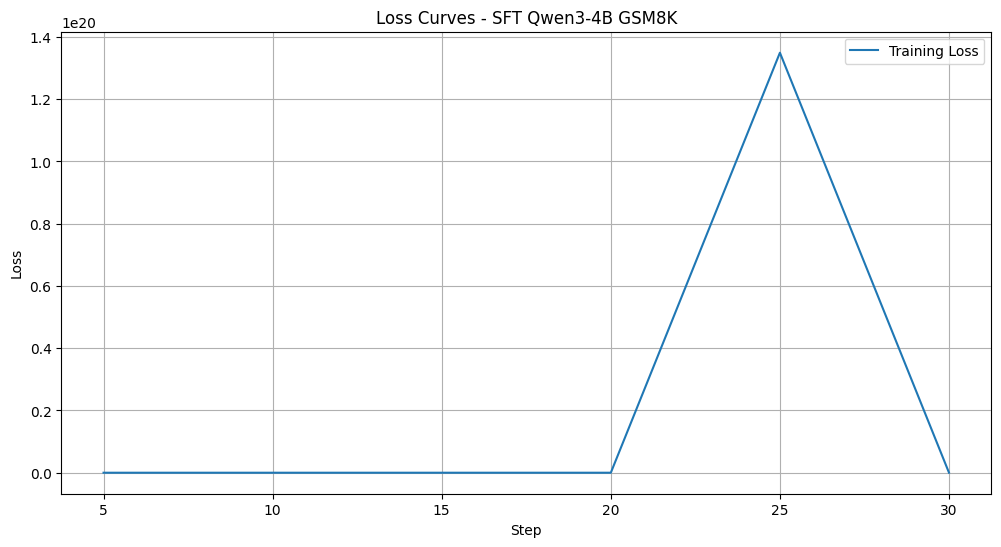

No logs found for metric: accuracy
Skipping eval_loss (not found)
Skipping accuracy (not found)


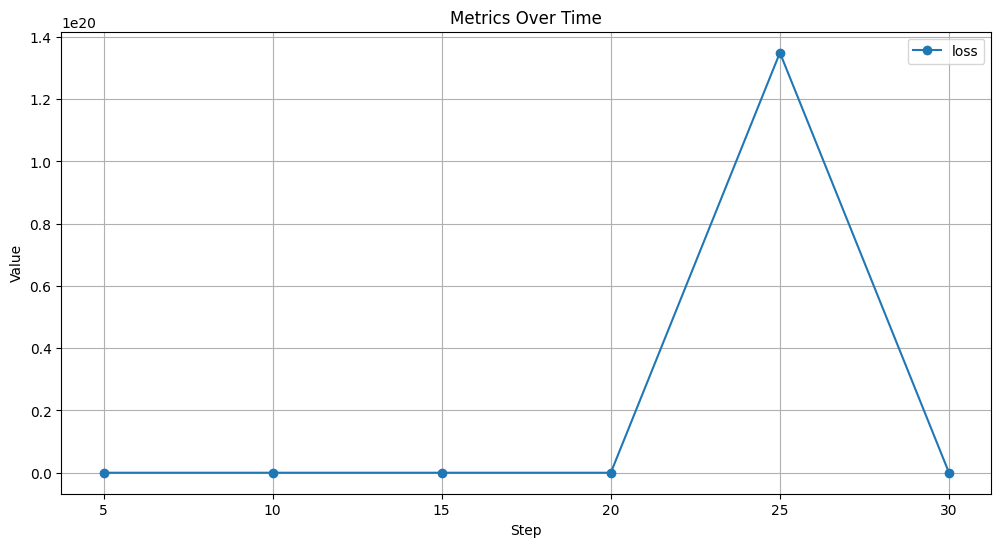

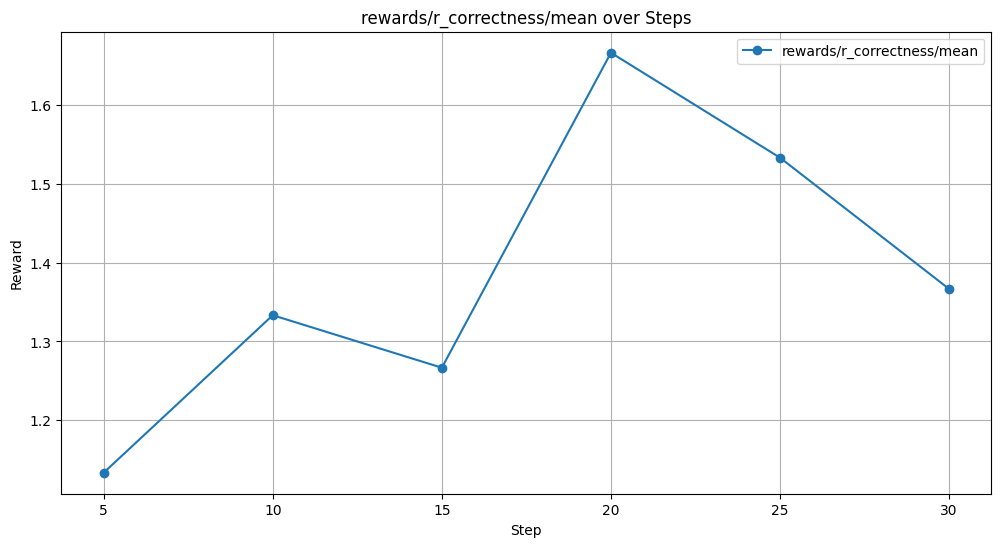

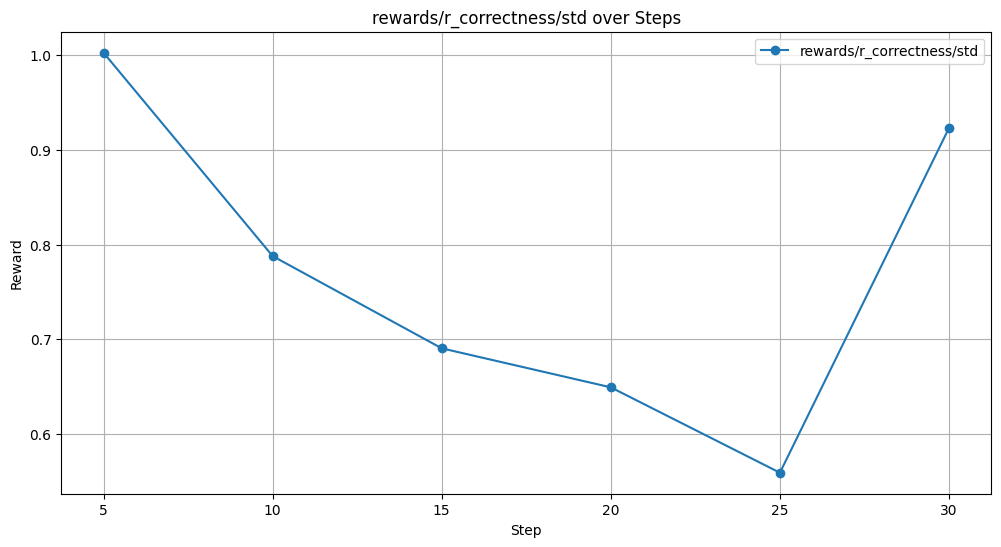

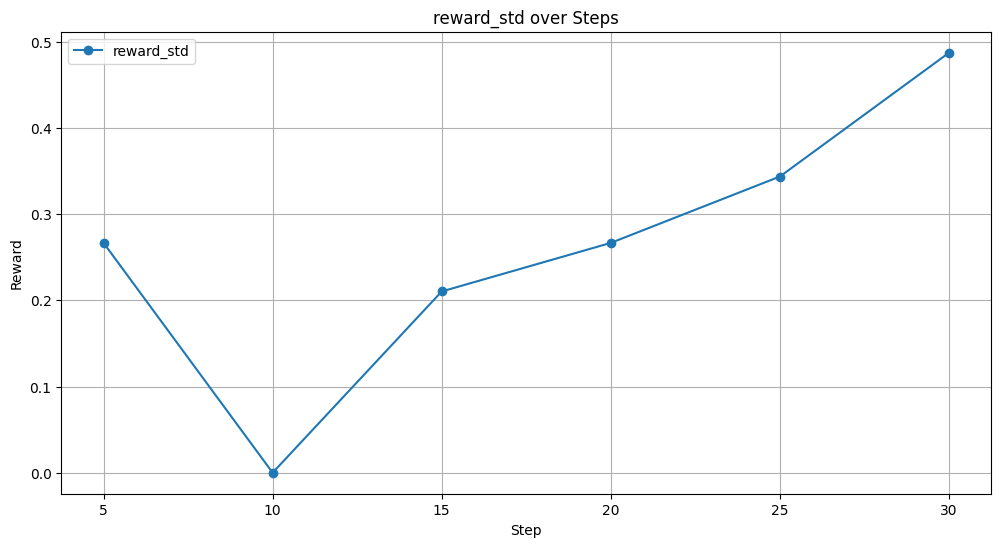

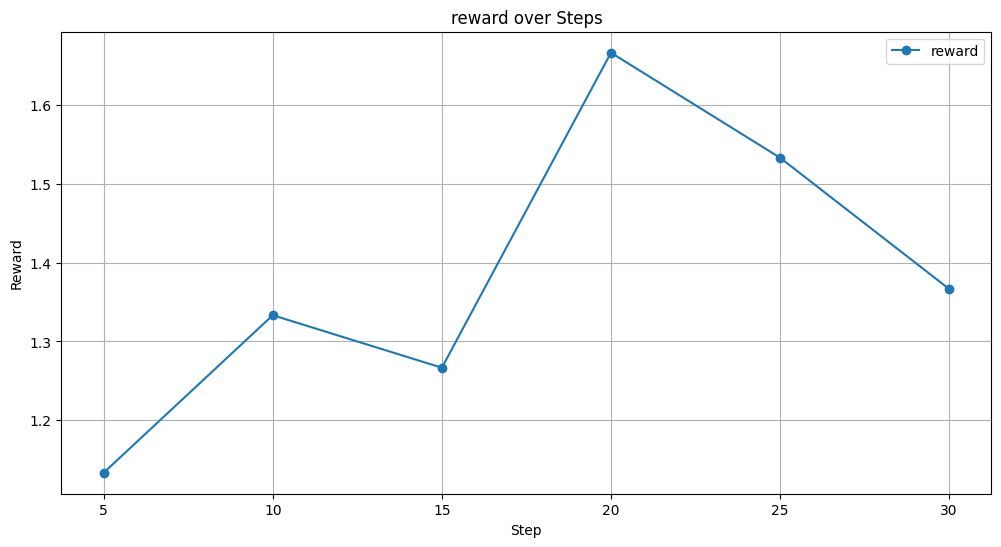

In [ ]:
log_history = trainer.state.log_history

plot_loss_curves(log_history, title="SFT Qwen3-4B GSM8K")
plot_metric(log_history, 'accuracy', title="Validation Accuracy")
plot_multiple_metrics(log_history, ['loss', 'eval_loss', 'accuracy'])
plot_reward_components(log_history)

### Accuracy test

In [20]:
# del trainer
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


#### test with 20 samples

In [ ]:

samples = random.sample(list(full_main_dataset), 20)

results = evaluate_self_consistency(
    model=model,
    tokenizer=tokenizer,
    dataset=samples,
    create_prompt=create_prompt,
    num_samples=5,
    batch_size=3,
    max_new_tokens=512,
)

print(f"Final accuracy: {results['accuracy']:.2f}%")


--- Starting evaluation with Self-Consistency (samples: 5) ---


Evaluating Batches:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:660: UserWarning: An output with one or more elements was resized since it had shape [1, 15, 2560], which does not match the required output shape [15, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /pytorch/aten/src/ATen/native/Resize.cpp:31.)
  out = torch_matmul(X, W.t(), out = out)
/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:665: UserWarning: An output with one or more elements was resized since it had shape [1, 15, 2560], which does not match the required output shape [15, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out 

Samples: ['700', '700', '700', '700', '700'] -> Voted: 700, Reference: 700
Samples: ['39', '39', '13', '14', '14'] -> Voted: 39, Reference: 39
Samples: ['7', '7', '7', '7', '7'] -> Voted: 7, Reference: 7


Evaluating Batches:  29%|██▊       | 2/7 [05:47<14:25, 173.06s/it]

Samples: ['96', '6', '48', '48', '16'] -> Voted: 48, Reference: 6
Samples: ['4', '4', '4', '4', '4'] -> Voted: 4, Reference: 4
Samples: ['142', '142', '142', '142', '142'] -> Voted: 142, Reference: 142


Evaluating Batches:  43%|████▎     | 3/7 [08:39<11:32, 173.02s/it]

Samples: ['130', '130', '130', '130', '130'] -> Voted: 130, Reference: 130
Samples: ['20', '3440', '21', '172', '20'] -> Voted: 20, Reference: 20
Samples: ['13', '13', '13', '13', '13'] -> Voted: 13, Reference: 13


/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:660: UserWarning: An output with one or more elements was resized since it had shape [1, 15, 2560], which does not match the required output shape [15, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /pytorch/aten/src/ATen/native/Resize.cpp:31.)
  out = torch_matmul(X, W.t(), out = out)
/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:665: UserWarning: An output with one or more elements was resized since it had shape [1, 15, 2560], which does not match the required output shape [15, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t

Samples: ['5', '570', '20', '100', '5'] -> Voted: 5, Reference: 570
Samples: ['81', '81', '81', '81', '81'] -> Voted: 81, Reference: 81
Samples: ['4096', '4096', '4096', '4096', '4096'] -> Voted: 4096, Reference: 4096


Evaluating Batches:  71%|███████▏  | 5/7 [14:27<05:47, 173.51s/it]

Samples: ['7', '7', '7', '7', '7'] -> Voted: 7, Reference: 7
Samples: ['110', '300', '410', '10', '810'] -> Voted: 110, Reference: 810
Samples: ['20', '20', '20', '20', '20'] -> Voted: 20, Reference: 20


Evaluating Batches:  86%|████████▌ | 6/7 [17:21<02:53, 173.74s/it]

Samples: ['60', '60', '60', '60', '60'] -> Voted: 60, Reference: 60
Samples: ['180', '610', '61', '610', '610'] -> Voted: 610, Reference: 180
Samples: ['19', '19', '19', '19', '19'] -> Voted: 19, Reference: 19


/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:660: UserWarning: An output with one or more elements was resized since it had shape [1, 10, 2560], which does not match the required output shape [10, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /pytorch/aten/src/ATen/native/Resize.cpp:31.)
  out = torch_matmul(X, W.t(), out = out)
/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:665: UserWarning: An output with one or more elements was resized since it had shape [1, 10, 2560], which does not match the required output shape [10, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t

Samples: ['24', '24', '24', '24', '24'] -> Voted: 24, Reference: 24
Samples: ['3', '4', '9', '5', '13'] -> Voted: 3, Reference: 13

--- Evaluation Complete ---
Correct Answers: 15 / 20
Accuracy: 75.00%
Final accuracy: 75.00%


#### test with 40 samples

In [18]:

samples = random.sample(list(full_main_dataset), 40)

results = evaluate_self_consistency(
    model=model,
    tokenizer=tokenizer,
    dataset=samples,
    create_prompt=create_prompt,
    num_samples=5,
    batch_size=6,
    max_new_tokens=512,
)

print(f"Final accuracy: {results['accuracy']:.2f}%")


--- Starting evaluation with Self-Consistency (samples: 5) ---


Evaluating Batches:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:660: UserWarning: An output with one or more elements was resized since it had shape [1, 30, 2560], which does not match the required output shape [30, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /pytorch/aten/src/ATen/native/Resize.cpp:31.)
  out = torch_matmul(X, W.t(), out = out)
/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:665: UserWarning: An output with one or more elements was resized since it had shape [1, 30, 2560], which does not match the required output shape [30, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out 

Samples: ['4', '84', '84', '6', '4'] -> Voted: 4, Reference: 84
Samples: ['100', '150', '000', '2', '5'] -> Voted: 100, Reference: 150
Samples: ['60', '60', '60', '60', '60'] -> Voted: 60, Reference: 60
Samples: ['84', '84', '84', '84', '84'] -> Voted: 84, Reference: 84
Samples: ['3', '3', '46', '46', '170'] -> Voted: 3, Reference: 46
Samples: ['139', '861', '42219', '3', '3'] -> Voted: 3, Reference: 32139


Evaluating Batches:  29%|██▊       | 2/7 [10:25<26:04, 312.86s/it]

Samples: ['480', '0', '000', '380', '000'] -> Voted: 000, Reference: 60000
Samples: ['216', '216', '216', '216', '216'] -> Voted: 216, Reference: 216
Samples: ['15', '15', '15', '15', '15'] -> Voted: 15, Reference: 15
Samples: ['70', '70', '70', '70', '70'] -> Voted: 70, Reference: 70
Samples: ['8', '8', '8', '8', '8'] -> Voted: 8, Reference: 8
Samples: ['16', '16', '16', '16', '16'] -> Voted: 16, Reference: 16


Evaluating Batches:  43%|████▎     | 3/7 [15:41<20:56, 314.04s/it]

Samples: ['600', '6', '6'] -> Voted: 6, Reference: 6
Samples: ['4', '4', '4', '4', '4'] -> Voted: 4, Reference: 4
Samples: ['5', '15', '80', '3', '155'] -> Voted: 5, Reference: 155
Samples: ['000', '000', '12000', '12000', '12000'] -> Voted: 12000, Reference: 12000
Samples: ['105', '45', '45', '45', '105'] -> Voted: 45, Reference: 45
Samples: ['96', '96', '96', '96', '96'] -> Voted: 96, Reference: 96


Evaluating Batches:  57%|█████▋    | 4/7 [21:02<15:50, 316.99s/it]

Samples: ['18', '300', '90', '68', '90'] -> Voted: 90, Reference: 22
Samples: ['325', '325', '325', '325', '325'] -> Voted: 325, Reference: 325
Samples: ['40', '40', '40', '40', '40'] -> Voted: 40, Reference: 40
Samples: ['32', '32', '32', '32', '32'] -> Voted: 32, Reference: 32
Samples: ['14', '14', '14', '14', '14'] -> Voted: 14, Reference: 14
Samples: ['20', '60', '60', '60', '60'] -> Voted: 60, Reference: 60


Evaluating Batches:  71%|███████▏  | 5/7 [26:13<10:29, 314.73s/it]

Samples: ['850', '780', '780', '780', '850'] -> Voted: 780, Reference: 70
Samples: ['9', '9', '9', '9', '9'] -> Voted: 9, Reference: 9
Samples: ['69', '69', '69', '69', '69'] -> Voted: 69, Reference: 69
Samples: ['10', '10', '10', '10', '10'] -> Voted: 10, Reference: 10
Samples: ['18', '18', '18', '18', '18'] -> Voted: 18, Reference: 18
Samples: ['12200', '12200', '12200', '12200', '12200'] -> Voted: 12200, Reference: 12200


Evaluating Batches:  86%|████████▌ | 6/7 [31:30<05:15, 315.36s/it]

Samples: ['700', '700', '000', '700', '700'] -> Voted: 700, Reference: 700
Samples: ['3', '330', '16.50', '330', '3'] -> Voted: 3, Reference: 95
Samples: ['1', '146', '146', '146', '1'] -> Voted: 146, Reference: 146
Samples: ['116', '116', '116', '116', '116'] -> Voted: 116, Reference: 116
Samples: ['87', '87', '87', '87', '87'] -> Voted: 87, Reference: 87
Samples: ['20', '20', '20', '20', '20'] -> Voted: 20, Reference: 20


/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:660: UserWarning: An output with one or more elements was resized since it had shape [1, 20, 2560], which does not match the required output shape [20, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /pytorch/aten/src/ATen/native/Resize.cpp:31.)
  out = torch_matmul(X, W.t(), out = out)
/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:665: UserWarning: An output with one or more elements was resized since it had shape [1, 20, 2560], which does not match the required output shape [20, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t

Samples: ['35', '99', '86', '99', '15'] -> Voted: 99, Reference: 99
Samples: ['50', '00', '000', '100', '100'] -> Voted: 100, Reference: 20
Samples: ['240', '240', '240', '240', '240'] -> Voted: 240, Reference: 240
Samples: ['1', '2', '20', '1'] -> Voted: 1, Reference: 1

--- Evaluation Complete ---
Correct Answers: 30 / 40
Accuracy: 75.00%
Final accuracy: 75.00%


## merge model and save

In [ ]:
print("\nMerging LoRA adapters for final evaluation...")
merged_model = model.merge_and_unload()
plot_curves(trainer.state.log_history)

merged_model.save_pretrained(GRPO_OUTPUT_DIR)

### push to hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import HfApi
api = HfApi()

api.create_repo(
    repo_id=ADAPTER_REPO,
    private=False,
    exist_ok=True
)

api.upload_folder(
    folder_path=GRPO_OUTPUT_DIR,
    repo_id=ADAPTER_REPO,
    repo_type="model",
    commit_message="Continue training: +5k steps on extra math data"
)



Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /content/output-grpo/tokenizer.json   : 100%|##########| 11.4MB / 11.4MB            

  ...tput-grpo/adapter_model.safetensors:   0%|          | 61.5kB /  529MB            

  /content/output-grpo/training_args.bin:   7%|6         |   478B / 7.06kB            

CommitInfo(commit_url='https://huggingface.co/tahamajs/Qwen3-4b-gsm8k-Qlora-GRPO/commit/f16a61e64d5c1f8047c3f897f36624eb3aea4001', commit_message='Continue training: +5k steps on extra math data', commit_description='', oid='f16a61e64d5c1f8047c3f897f36624eb3aea4001', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tahamajs/Qwen3-4b-gsm8k-Qlora-GRPO', endpoint='https://huggingface.co', repo_type='model', repo_id='tahamajs/Qwen3-4b-gsm8k-Qlora-GRPO'), pr_revision=None, pr_num=None)